# inport packages

In [ ]:
# !pip install dbfread

In [ ]:
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
try:
    from dbfread import DBF
except ImportError:
    !pip install dbfread
    from dbfread import DBF
# from scipy.stats import pearsonr
import scipy.stats as stats
import seaborn as sns
import itertools
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import sklearn.ensemble as ensemble
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# goole Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/final7013/NYCUHI")

# history data
In this section, we will import the population, LST, LULC and DEM data from 2005-2020. Perform data cleaning, descriptive statistics, correlation analysis, regularization on them, establish OLS and random forest models to predict LST, and verify them.

## Import Data

In [ ]:
X_his_root = 'Processed Data/IndependentVariableX/HistoricalData'
def readData(path):
     # file root
    table = DBF(path, encoding='GBK')
    df = pd.DataFrame(iter(table))
    return df
POP_his_df={}
LULC_his_df={}
LST_his_df={}
DEM_his_df={}

In [ ]:
for i in range(2005,2021,5):
    path1=X_his_root+'/Pop_HIS_Table/Proj_usa_ppp_'+str(i)+'_UNadj_Table.dbf'
    path2='./Processed Data/因变量LST/LST'+str(i)+'.dbf'# LST
    if i==2010:
        path3=X_his_root+'/LULC_HIS_Table/reclass_nlcd_'+str(i)+'.dbf'
    else:
        path3=X_his_root+'/LULC_HIS_Table/reclass_nlcd_'+str(i+1)+'.dbf'
    POP_his_df[str(i)]=readData(path1)
    LST_his_df[str(i)]=readData(path2)
    LULC_his_df[str(i)]=readData(path3)
    DEM_his_df[str(i)]=readData('Processed Data/IndependentVariableX/HistoricalData/DEM_Table/DEM_Table.dbf')

In [ ]:
# DEM_his_df=readData('Processed Data/IndependentVariableX/HistoricalData/DEM_Table/DEM_Table.dbf')

## Clean Data

In POP, the data in LULC is incomplete, and there are missing values in LST.

1. Remove missing values
2. Remove LULC>980100
3. Remove LULC3+4/sum<0.4
4. Whether to remove LULC2>0.3
5. Do you want to remove pop==0? (Comments section)

In [ ]:
for i in range(2005,2021,5):
  # 1.
  LST_his_df[str(i)].dropna(inplace=True)
  LST_his_df[str(i)].reset_index(drop=True,inplace=True)
  # 2.
  LULC_his_df[str(i)]['Row_sum'] = LULC_his_df[str(i)].iloc[:,1:].sum(axis=1)
  LULC_his_df[str(i)]=LULC_his_df[str(i)][(LULC_his_df[str(i)]['Row_sum']>=980100)]
  # 3.
  LULC_his_df[str(i)]=LULC_his_df[str(i)][(LULC_his_df[str(i)]['VALUE_3']+LULC_his_df[str(i)]['VALUE_4'])/LULC_his_df[str(i)]['Row_sum']>=0.4]
  # 4.
  LULC_his_df[str(i)]=LULC_his_df[str(i)][LULC_his_df[str(i)]['VALUE_2']/LULC_his_df[str(i)]['Row_sum']<=0.3]
  LULC_his_df[str(i)].reset_index(drop=True,inplace=True)
  # 5.
  POP_his_df[str(i)]=POP_his_df[str(i)][POP_his_df[str(i)]['SUM']!=0]

  POP_his_df[str(i)].reset_index(drop=True,inplace=True)
  index_l=list(set(POP_his_df[str(i)]['FID_']) & set(LULC_his_df[str(i)]['FID_'])& set(LST_his_df[str(i)]['FID_'])& set(DEM_his_df[str(i)]['FID_']))
  LST_his_df[str(i)]=LST_his_df[str(i)][LST_his_df[str(i)]['FID_'].isin(index_l)].reset_index(drop=True)
  LULC_his_df[str(i)]=(LULC_his_df[str(i)][LULC_his_df[str(i)]['FID_'].isin(index_l)]).reset_index(drop=True)
  POP_his_df[str(i)]=(POP_his_df[str(i)][POP_his_df[str(i)]['FID_'].isin(index_l)]).reset_index(drop=True)
  DEM_his_df[str(i)] = (DEM_his_df[str(i)][DEM_his_df[str(i)]['FID_'].isin(index_l)]).reset_index(drop=True)

## Describe Data

In [ ]:
for i in ['2005','2010','2015','2020']:
    print(i+"\n")
    print("LST_his_df\n")
    print(LST_his_df[i].describe())
    print("LULC_his_df\n")
    print(LULC_his_df[i].describe())
    print("POP_his_df\n")
    print(POP_his_df[i].describe())
    print("DEM_his_df\n")
    print(DEM_his_df[i].describe())
    print("\n\n")

2005

LST_his_df

               FID_   COUNT       AREA         MEAN
count   6001.000000  6001.0     6001.0  6001.000000
mean   12022.585569     1.0  1000000.0   306.086798
std     5437.158302     0.0        0.0     3.053492
min       16.000000     1.0  1000000.0   296.960000
25%     8295.000000     1.0  1000000.0   304.248889
50%    11190.000000     1.0  1000000.0   306.205000
75%    14225.000000     1.0  1000000.0   308.118000
max    34244.000000     1.0  1000000.0   315.944444
LULC_his_df

               FID_        VALUE_1        VALUE_2        VALUE_3  \
count   6001.000000    6001.000000    6001.000000    6001.000000   
mean   12022.585569   82530.794868   11030.811531  490890.834861   
std     5437.158302  122501.187266   34515.260714  179014.297202   
min       16.000000       0.000000       0.000000       0.000000   
25%     8295.000000     900.000000       0.000000  378000.000000   
50%    11190.000000   18900.000000       0.000000  477900.000000   
75%    14225.000000  1188

### hist figure

#### Population

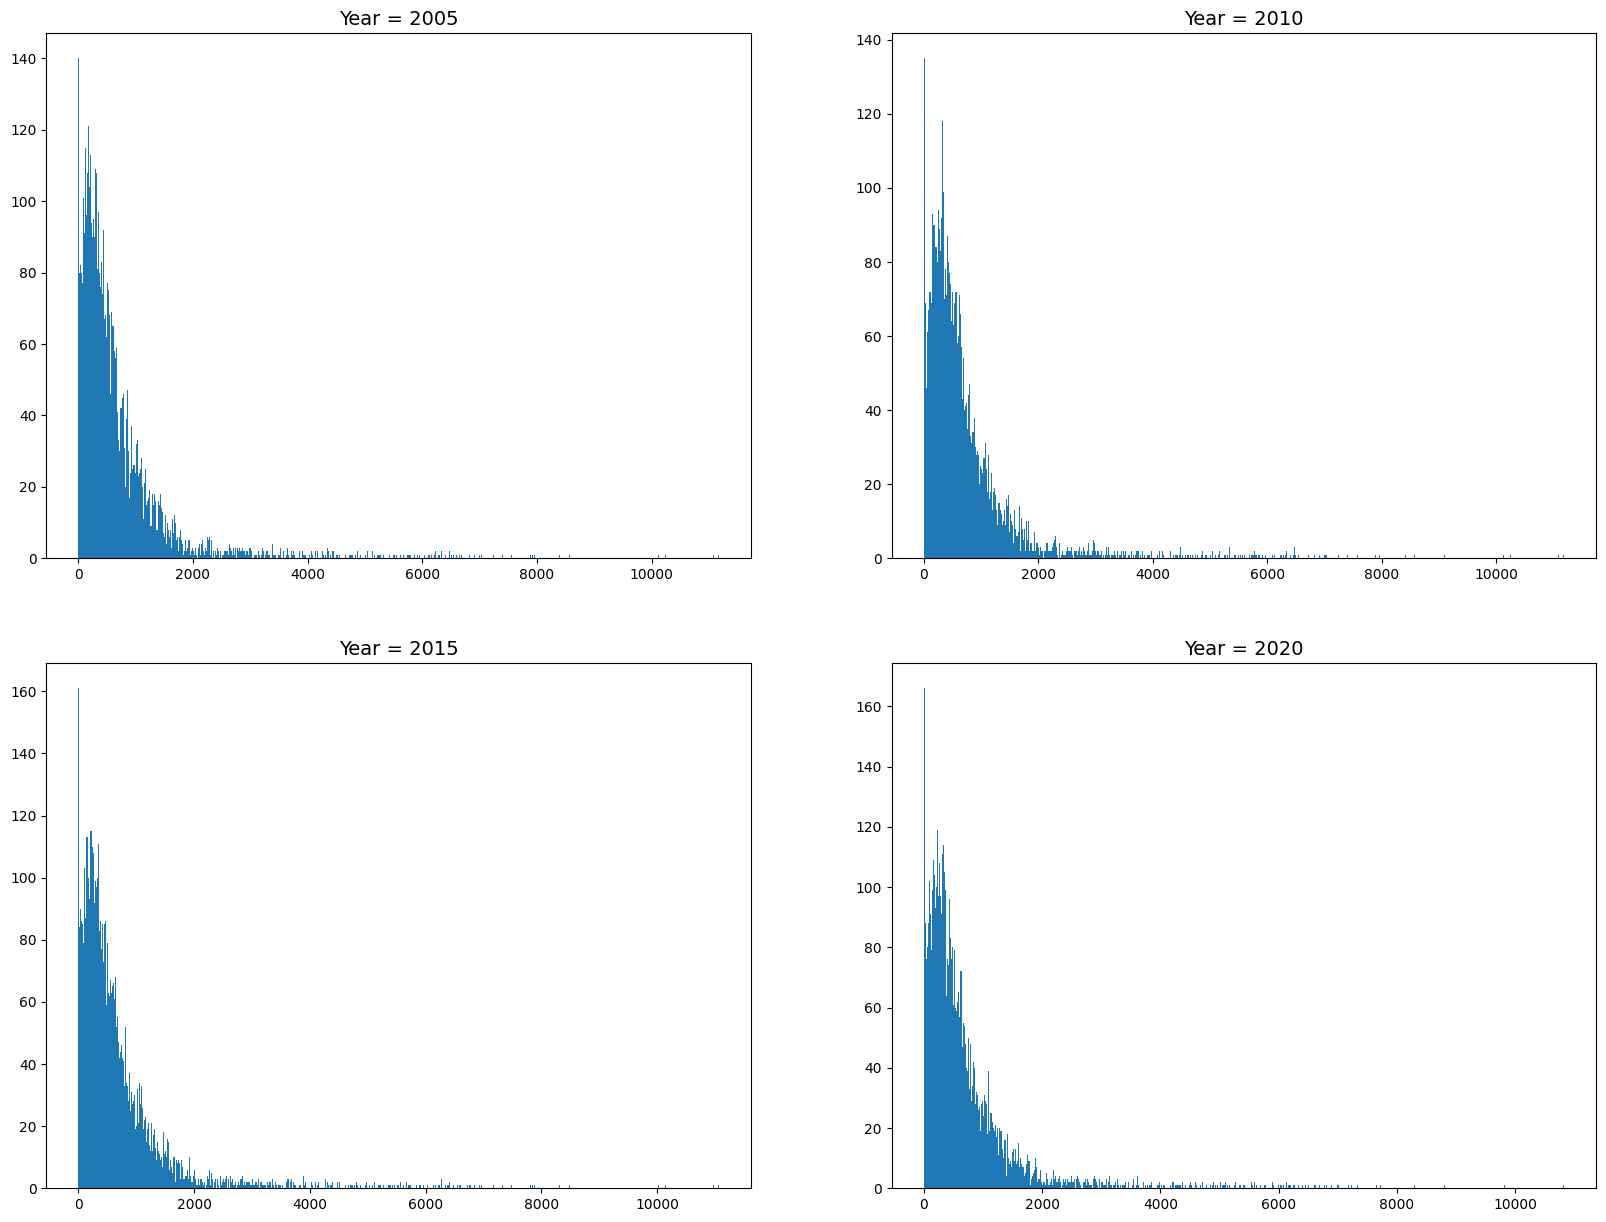

In [ ]:
plt.figure(figsize = (20,15))
for i in ['2005','2010','2015','2020']:
  a=int(((int(i)-2000)/5))
  plt.subplot(220+a)
  plt.hist(POP_his_df[i]['SUM'],bins=800)
  plt.title('Year = '+i, fontsize = 14)

#### LULC

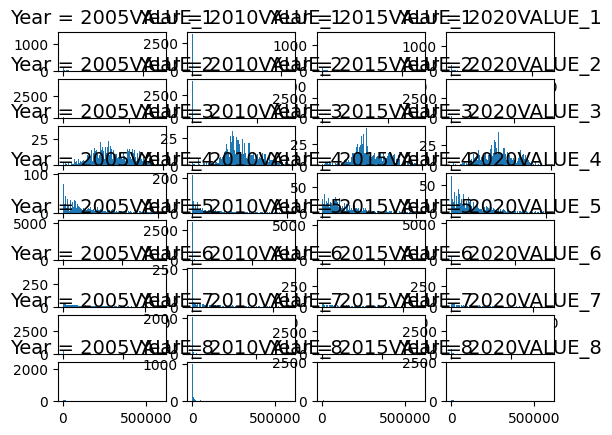

In [ ]:
plt.figure()
for n in range(1,9):
  for i in ['2005','2010','2015','2020']:
    a,b=n-1,int(((int(i)-2000)/5)-1)
    plt.subplot2grid((8,4), (a,b))
    j=str(n)
    plt.hist(LULC_his_df[i]['VALUE_'+j],bins=800)
    plt.title('Year = '+i+'VALUE_'+j, fontsize = 14)

#### DEM

<ipython-input-14-2a00ccad094b>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(220+a)


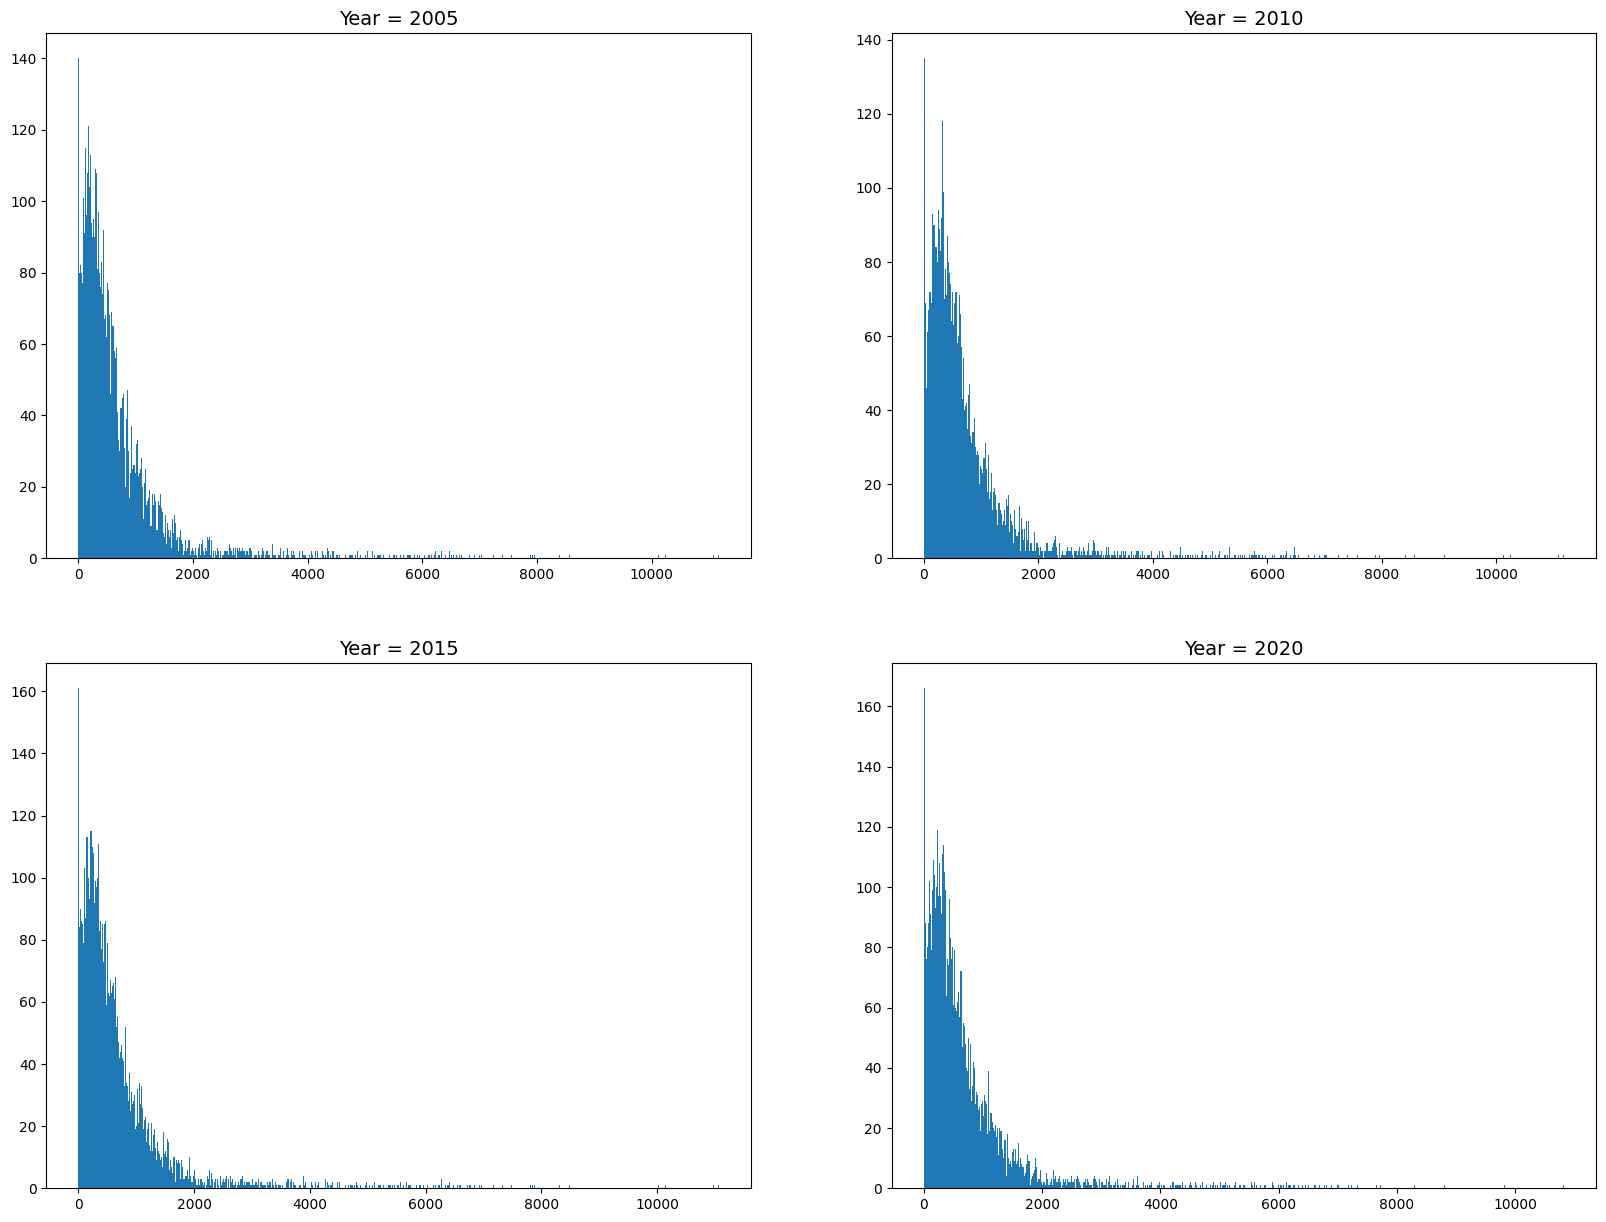

In [ ]:
plt.figure(figsize = (20,15))
plt.title('Historical Population'+i, fontsize = 18)
for i in ['2005','2010','2015','2020']:
  a=int(((int(i)-2000)/5))
  plt.subplot(220+a)
  plt.hist(POP_his_df[i]['SUM'],bins=800)
  plt.title('Year = '+i, fontsize = 14)

#### LST

<ipython-input-15-2a00ccad094b>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(220+a)


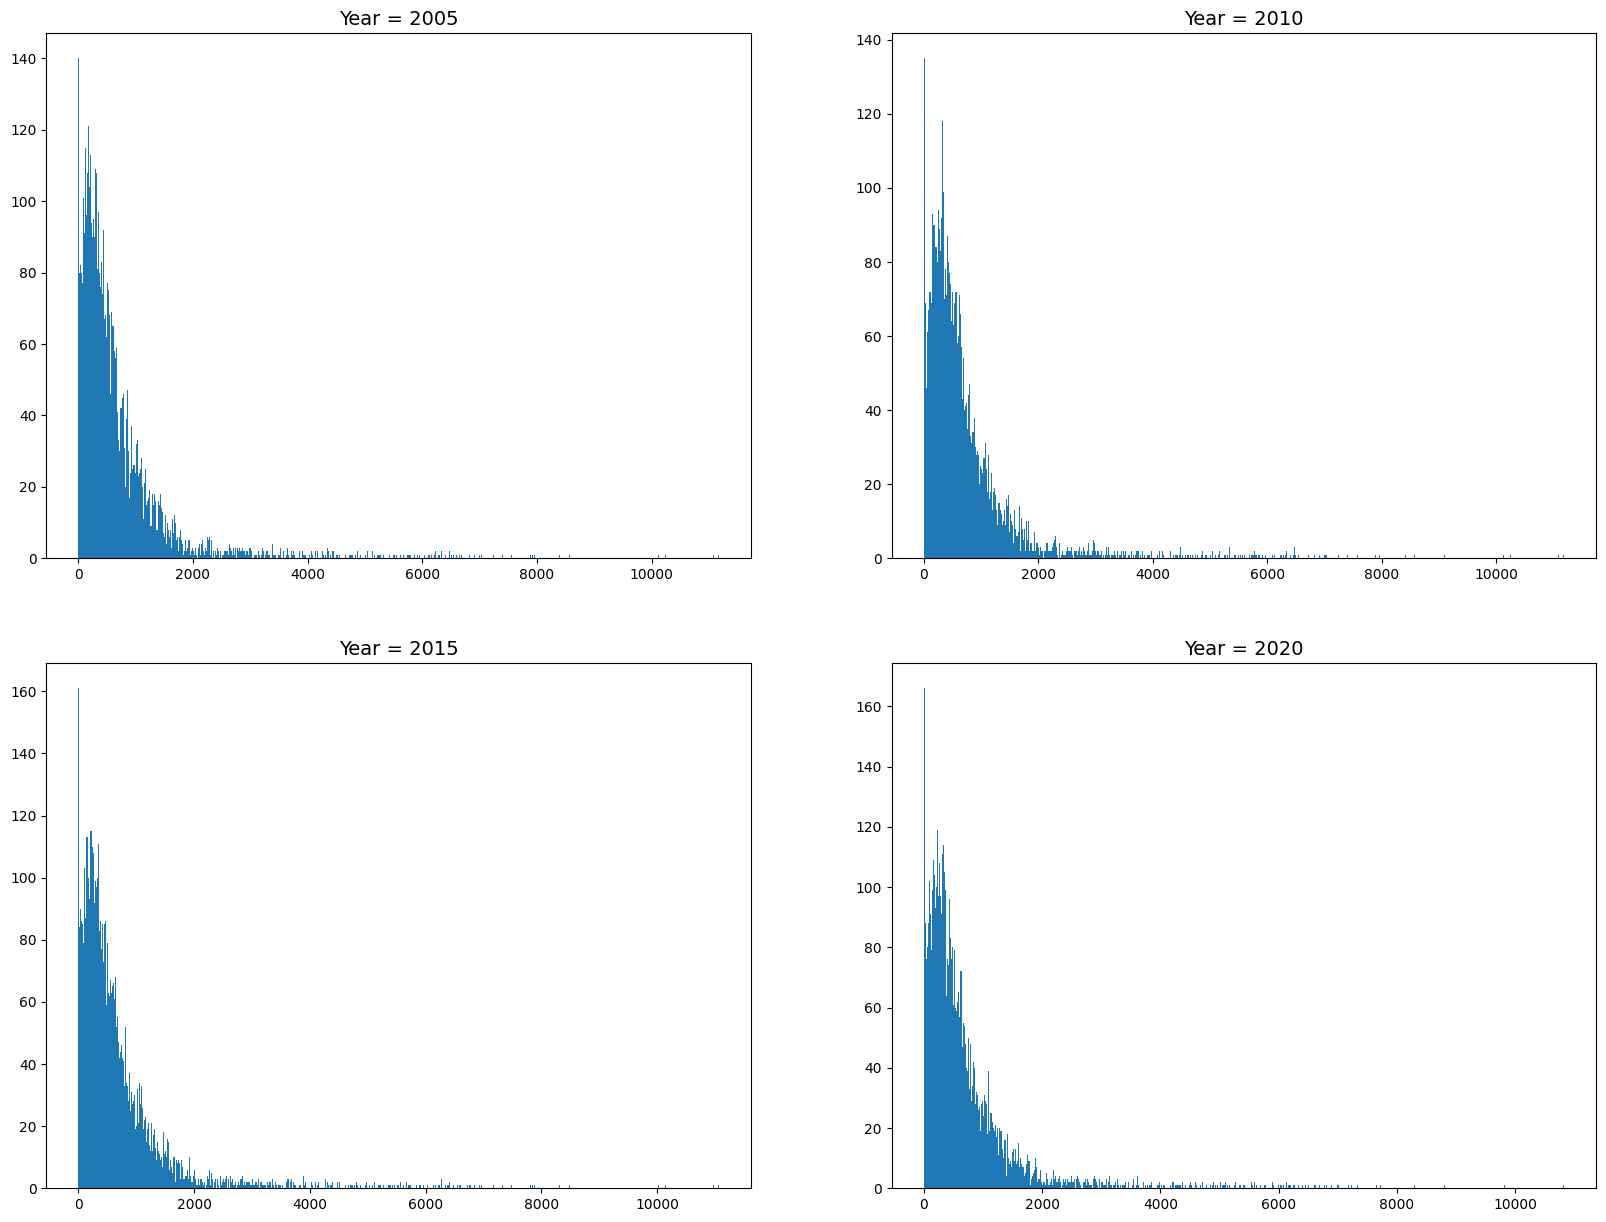

In [ ]:
plt.figure(figsize = (20,15))
plt.title('Historical Population'+i, fontsize = 18)
for i in ['2005','2010','2015','2020']:
  a=int(((int(i)-2000)/5))
  plt.subplot(220+a)
  plt.hist(POP_his_df[i]['SUM'],bins=800)
  plt.title('Year = '+i, fontsize = 14)

## LST plot

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# x_axis_data = [2005,2010,2015,2020] #x
# y_axis_data = [68,69,79,71,80,70,66] #y

# plt.plot(x_axis_data, y_axis_data, 'b*--', alpha=0.5, linewidth=1, label='acc')#'bo-'表示蓝色实线，数据点实心原点标注
# ## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，

# plt.legend()  #显示上面的label
# plt.xlabel('time') #x_label
# plt.ylabel('number')#y_label

# #plt.ylim(-1,1)#仅设置y轴坐标范围
# plt.show()


## by year

In [ ]:
dataByYear={}

for i in ['2005','2010','2015','2020']:
  dataByYear[i]=pd.DataFrame({
      "LST":LST_his_df[i]['MEAN'],
      "LULC_1":LULC_his_df[i]["VALUE_1"]/LULC_his_df[i]["Row_sum"],
      "LULC_2":LULC_his_df[i]["VALUE_2"]/LULC_his_df[i]["Row_sum"],
      "LULC_3":LULC_his_df[i]["VALUE_3"]/LULC_his_df[i]["Row_sum"],
      "LULC_4":LULC_his_df[i]["VALUE_4"]/LULC_his_df[i]["Row_sum"],
      "LULC_5":LULC_his_df[i]["VALUE_5"]/LULC_his_df[i]["Row_sum"],
      "LULC_6":LULC_his_df[i]["VALUE_6"]/LULC_his_df[i]["Row_sum"],
      "LULC_7":LULC_his_df[i]["VALUE_7"]/LULC_his_df[i]["Row_sum"],
      "LULC_8":LULC_his_df[i]["VALUE_8"]/LULC_his_df[i]["Row_sum"],
      "DEM":DEM_his_df[i]['MEAN'],
      "POP":POP_his_df[i]['SUM'],
      "year":np.full(len(DEM_his_df[i]), int(i))
  })
# dataByYear[i].to_csv('./cleanedData/.csv')
fullData=pd.concat([dataByYear['2005'],dataByYear['2010'],dataByYear['2015'],dataByYear['2020']])
# data_2020=pd.DataFrame({
#     "LST":LST_his_df['2020']['MEAN'],
#     "LULC_1":LULC_his_df['2020']["VALUE_1"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_2":LULC_his_df['2020']["VALUE_2"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_3":LULC_his_df['2020']["VALUE_3"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_4":LULC_his_df['2020']["VALUE_4"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_5":LULC_his_df['2020']["VALUE_5"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_6":LULC_his_df['2020']["VALUE_6"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_7":LULC_his_df['2020']["VALUE_7"]/LULC_his_df['2020']["Row_sum"],
#     "LULC_8":LULC_his_df['2020']["VALUE_8"]/LULC_his_df['2020']["Row_sum"],
#     "DEM":DEM_his_df['2020']['MEAN'],
#     "POP":POP_his_df['2020']['SUM'],
#     "year":np.full(len(DEM_his_df['2020']), 2020)
# })
# data_2020=pd.DataFrame({
#     "LST":LST_his_df['2020']['MEAN'],
#     "LULC_1":LULC_his_df['2020']["VALUE_1"],
#     "LULC_2":LULC_his_df['2020']["VALUE_2"],
#     "LULC_3":LULC_his_df['2020']["VALUE_3"],
#     "LULC_4":LULC_his_df['2020']["VALUE_4"],
#     "LULC_5":LULC_his_df['2020']["VALUE_5"],
#     "LULC_6":LULC_his_df['2020']["VALUE_6"],
#     "LULC_7":LULC_his_df['2020']["VALUE_7"],
#     "LULC_8":LULC_his_df['2020']["VALUE_8"],
#     "DEM":DEM_his_df['2020']['MEAN'],
#     "POP":POP_his_df['2020']['SUM'],

# })
List=list(itertools.combinations(dataByYear['2020'].keys(),2))


#### export Cleaned Data

In [ ]:
# output={}
# for i in ['2005','2010','2015','2020']:
#   output[i]=pd.DataFrame({
#       "FID":DEM_his_df[i]['FID_'],
#       "LST":LST_his_df[i]['MEAN'],
#       "LULC_1":LULC_his_df[i]["VALUE_1"]/LULC_his_df[i]["Row_sum"],
#       "LULC_2":LULC_his_df[i]["VALUE_2"]/LULC_his_df[i]["Row_sum"],
#       "LULC_3":LULC_his_df[i]["VALUE_3"]/LULC_his_df[i]["Row_sum"],
#       "LULC_4":LULC_his_df[i]["VALUE_4"]/LULC_his_df[i]["Row_sum"],
#       "LULC_5":LULC_his_df[i]["VALUE_5"]/LULC_his_df[i]["Row_sum"],
#       "LULC_6":LULC_his_df[i]["VALUE_6"]/LULC_his_df[i]["Row_sum"],
#       "LULC_7":LULC_his_df[i]["VALUE_7"]/LULC_his_df[i]["Row_sum"],
#       "LULC_8":LULC_his_df[i]["VALUE_8"]/LULC_his_df[i]["Row_sum"],
#       "DEM":DEM_his_df[i]['MEAN'],
#       "POP":POP_his_df[i]['SUM'],
#       "year":np.full(len(DEM_his_df[i]), int(i))
#   })
#   output[i].to_csv('./Cleaned Data/'+i+'.csv')

## Correlation analysis

Correlation analysis: Calculate Pearson correlation of LST vs pop, DEM and LandUse Type Percentage for each pixel. And compare the difference between urban area and rural. And choose the most correlated variables as features in the model. (((If the regression is not performed on each pixel, but on the entire urban area and rural area, if the residuals have spatial heterogeneity, you can verify that LST may have spatial autocorrelation (Moran index. If so, use Geodetector selection factors.

In [ ]:
fullData.describe()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
count,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000
mean,306.391603,0.072426,0.010529,0.495938,0.213199,0.001877,0.155886,0.007286,0.042858,90.340354,724.986307,2012.689534
std,3.280393,0.114775,0.033642,0.179840,0.214212,0.011926,0.141196,0.022555,0.076688,100.970454,947.796524,5.623080
min,295.426000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.836757,0.005911,2005.000000
25%,304.322000,0.000000,0.000000,0.382353,0.054178,0.000000,0.036731,0.000000,0.000000,22.621065,226.397270,2010.000000
50%,306.453250,0.011019,0.000000,0.483930,0.145087,0.000000,0.116756,0.000000,0.007130,70.599018,459.607187,2015.000000
75%,308.668000,0.098930,0.000918,0.619430,0.299465,0.000000,0.242424,0.003565,0.049587,115.483180,855.231739,2020.000000
max,317.314000,0.592692,0.298574,0.991736,1.000000,0.336088,0.598930,0.394858,0.569204,649.331995,11186.639513,2020.000000


In [ ]:
Corr=fullData.corr(method='pearson')
Corr

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
LST,1.000000,-0.238727,-0.083048,-0.034189,0.518109,-0.002616,-0.495540,0.008410,-0.063019,-0.591892,0.456317,-0.056269
LULC_1,-0.238727,1.000000,-0.101397,-0.210233,-0.258837,0.006326,-0.100449,0.032294,-0.061688,0.002313,-0.269233,0.038028
LULC_2,-0.083048,-0.101397,1.000000,-0.177968,0.013236,0.062417,-0.032602,0.002060,0.143166,0.029086,-0.070185,-0.006304
LULC_3,-0.034189,-0.210233,-0.177968,1.000000,-0.566099,-0.110156,-0.083351,-0.068701,-0.180285,0.038066,-0.191910,-0.048512
LULC_4,0.518109,-0.258837,0.013236,-0.566099,1.000000,0.015473,-0.503388,-0.115020,-0.125911,-0.264107,0.615643,0.045360
LULC_5,-0.002616,0.006326,0.062417,-0.110156,0.015473,1.000000,0.003255,0.094345,-0.010998,0.007231,-0.061163,0.003552
LULC_6,-0.495540,-0.100449,-0.032602,-0.083351,-0.503388,0.003255,1.000000,0.084855,-0.100429,0.454086,-0.348063,-0.029430
LULC_7,0.008410,0.032294,0.002060,-0.068701,-0.115020,0.094345,0.084855,1.000000,-0.031858,0.025320,-0.111442,-0.092189
LULC_8,-0.063019,-0.061688,0.143166,-0.180285,-0.125911,-0.010998,-0.100429,-0.031858,1.000000,-0.212388,-0.152753,0.013657
DEM,-0.591892,0.002313,0.029086,0.038066,-0.264107,0.007231,0.454086,0.025320,-0.212388,1.000000,-0.196603,0.008589


In [ ]:
# sns.heatmap(Corr_2020,linewidths=0.8,vmax=1.0, square=True,linecolor='white', annot=True)

In [ ]:
p_fullData= pd.DataFrame(columns=Corr.columns,index=Corr.index)
p_fullData

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
LST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in List:
    i=i+stats.pearsonr(fullData[i[0]],fullData[i[1]])
    p_fullData[i[0]][i[1]]=i[3]
    print(i)

('LST', 'LULC_1', -0.23872668469767871, 2.6697308085e-313)
('LST', 'LULC_2', -0.08304836820582356, 1.3079781368555272e-38)
('LST', 'LULC_3', -0.03418907595458051, 9.192093988501525e-08)
('LST', 'LULC_4', 0.5181089734738783, 0.0)
('LST', 'LULC_5', -0.0026162721565603495, 0.6827809076558702)
('LST', 'LULC_6', -0.4955398538063253, 0.0)
('LST', 'LULC_7', 0.008410263385500077, 0.18893542897001347)
('LST', 'LULC_8', -0.06301920860598437, 6.612607334710589e-23)
('LST', 'DEM', -0.5918917086942336, 0.0)
('LST', 'POP', 0.4563170438942826, 0.0)
('LST', 'year', -0.056269021264494685, 1.4129889412875554e-18)
('LULC_1', 'LULC_2', -0.10139722453739755, 8.783453087893742e-57)
('LULC_1', 'LULC_3', -0.21023266868629711, 7.502570551563057e-242)
('LULC_1', 'LULC_4', -0.25883696533696127, 0.0)
('LULC_1', 'LULC_5', 0.006325607102300357, 0.3231079964494661)
('LULC_1', 'LULC_6', -0.1004493998127384, 9.37143611861054e-56)
('LULC_1', 'LULC_7', 0.03229376649052748, 4.518359740938192e-07)
('LULC_1', 'LULC_8', -0.

In [ ]:
pd.options.display.precision = 4
p_fullData

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
LST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_4,0.0,0.0,0.0387,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_5,0.6828,0.3231,0.0,0.0,0.0156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LULC_6,0.0,0.0,0.0,0.0,0.0,0.6112,NaN,NaN,NaN,NaN,NaN,NaN
LULC_7,0.1889,0.0,0.7477,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
LULC_8,0.0,0.0,0.0,0.0,0.0,0.0858,0.0,0.0,NaN,NaN,NaN,NaN
DEM,0.0,0.7179,0.0,0.0,0.0,0.2587,0.0,0.0001,0.0,NaN,NaN,NaN


In [ ]:
f1='LST ~ '+'+'.join(fullData.columns[1:])
f1

'LST ~ LULC_1+LULC_2+LULC_3+LULC_4+LULC_5+LULC_6+LULC_7+LULC_8+DEM+POP+year'

The larger the VIF value, the more obvious the collinearity problem, and 10 is usually used as the judgment boundary. When VIF<10, there is no multicollinearity; when 10<=VIF<100, there is strong multicollinearity; when VIF>=100, there is severe multicollinearity.

In [ ]:
reg = smf.ols(formula=f1, data = fullData)
results = reg.fit()
from statsmodels.stats.outliers_influence import variance_inflation_factor

exog = reg.exog
exog_names = reg.exog_names

vif = []
for i in range(exog.shape[1]-1):
    vif.append(variance_inflation_factor(exog,i+1))
    print(f'{exog_names[i+1]} 的方差膨胀因子VIF = {vif[i]}')

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


LULC_1 的方差膨胀因子VIF = inf
LULC_2 的方差膨胀因子VIF = inf
LULC_3 的方差膨胀因子VIF = inf
LULC_4 的方差膨胀因子VIF = inf
LULC_5 的方差膨胀因子VIF = inf
LULC_6 的方差膨胀因子VIF = inf
LULC_7 的方差膨胀因子VIF = inf
LULC_8 的方差膨胀因子VIF = inf
DEM 的方差膨胀因子VIF = 1.3294560299453309
POP 的方差膨胀因子VIF = 1.7349619679736752
year 的方差膨胀因子VIF = 1.0154654044781355


LULC_1, LULC_6 >100. so delete L6

In [ ]:
f2='LST ~ '+'+'.join(fullData.columns[1:6].append(fullData.columns[7:]))
f2

'LST ~ LULC_1+LULC_2+LULC_3+LULC_4+LULC_5+LULC_7+LULC_8+DEM+POP+year'

In [ ]:
reg2 = smf.ols(formula=f2, data = fullData)
results = reg2.fit()
from statsmodels.stats.outliers_influence import variance_inflation_factor

exog = reg2.exog
exog_names = reg2.exog_names
vif = []
for i in range(exog.shape[1]-1):
    vif.append(variance_inflation_factor(exog,i+1))
    print(f'{exog_names[i+1]} 的方差膨胀因子VIF = {vif[i]}')


LULC_1 的方差膨胀因子VIF = 1.6813426784748922
LULC_2 的方差膨胀因子VIF = 1.1085648271291355
LULC_3 的方差膨胀因子VIF = 2.858186818872231
LULC_4 的方差膨胀因子VIF = 3.810340795097408
LULC_5 的方差膨胀因子VIF = 1.0340526280253473
LULC_7 的方差膨胀因子VIF = 1.0929477197476203
LULC_8 的方差膨胀因子VIF = 1.469162515189857
DEM 的方差膨胀因子VIF = 1.3294560299453309
POP 的方差膨胀因子VIF = 1.7349619679736752
year 的方差膨胀因子VIF = 1.0154654044781353


# Normalization

## Normalize the data except 2005 - train the model

In [ ]:
df = fullData

In [ ]:
df.head()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
0,303.2640,0.2977,0.0000,0.3298,0.1595,0.0,0.0419,0.0000,0.1711,11.2101,73.2147,2005
1,302.6289,0.3159,0.0000,0.3756,0.0551,0.0,0.0634,0.0009,0.1892,9.2329,163.8643,2005
2,302.3760,0.2175,0.0027,0.4697,0.0169,0.0,0.2513,0.0053,0.0365,9.7361,189.6371,2005
3,305.1244,0.0569,0.0000,0.5436,0.3967,0.0,0.0009,0.0000,0.0018,7.5387,308.8798,2005
4,304.3578,0.1157,0.0000,0.5234,0.2323,0.0,0.0781,0.0000,0.0505,6.8683,276.2893,2005


In [ ]:
# Filter data except for 2005
df  = df[df['year'] != 2005].copy()

In [ ]:
df.head()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
0,309.856,0.0624,0.0000,0.5482,0.3682,0.0000,0.0092,0.0046,0.0073,7.5387,390.2333,2010
1,307.692,0.0964,0.0000,0.4747,0.2048,0.0092,0.1157,0.0230,0.0762,6.8683,321.5212,2010
2,306.436,0.2629,0.0018,0.5481,0.0169,0.0027,0.1034,0.0143,0.0499,7.1243,385.7429,2010
3,306.886,0.2837,0.0000,0.5493,0.0787,0.0043,0.0398,0.0035,0.0407,7.5685,254.8219,2010
4,307.098,0.1435,0.0000,0.4501,0.1881,0.0223,0.0918,0.0160,0.0882,6.6699,251.9394,2010


In [ ]:
# df['LULC_combined']  = df['LULC_1'] + df['LULC_2'] + df['LULC_3']+ df['LULC_4']+ df['LULC_5']+ df['LULC_7']+ df['LULC_8']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# InitializeMinMaxScaler
scaler = MinMaxScaler()
# Normalize DEM, POP and year
df[['LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']] = scaler.fit_transform(df[['LULC_1','LULC_2','LULC_3','LULC_4','LULC_5',	'LULC_7','LULC_8','DEM','POP','year']])


In [ ]:
data_normalize_train=df
data_normalize_train.head()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,...,LULC_1_scaled,LULC_2_scaled,LULC_3_scaled,LULC_4_scaled,LULC_5_scaled,LULC_7_scaled,LULC_8_scaled,DEM_scaled,POP_scaled,year_scaled
0,309.856,0.0624,0.0000,0.5482,0.3682,0.0000,0.0092,0.0046,0.0073,7.5387,...,0.1054,0.000,0.5528,0.3682,0.0000,0.0116,0.0129,0.0103,0.0349,0.0
1,307.692,0.0964,0.0000,0.4747,0.2048,0.0092,0.1157,0.0230,0.0762,6.8683,...,0.1627,0.000,0.4787,0.2048,0.0273,0.0581,0.1339,0.0093,0.0287,0.0
2,306.436,0.2629,0.0018,0.5481,0.0169,0.0027,0.1034,0.0143,0.0499,7.1243,...,0.4436,0.006,0.5527,0.0169,0.0080,0.0361,0.0877,0.0097,0.0345,0.0
3,306.886,0.2837,0.0000,0.5493,0.0787,0.0043,0.0398,0.0035,0.0407,7.5685,...,0.4787,0.000,0.5539,0.0787,0.0129,0.0088,0.0714,0.0104,0.0228,0.0
4,307.098,0.1435,0.0000,0.4501,0.1881,0.0223,0.0918,0.0160,0.0882,6.6699,...,0.2421,0.000,0.4538,0.1881,0.0663,0.0406,0.1550,0.0090,0.0225,0.0


# Normalization+OLS

In [ ]:
X = df[['LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM_scaled','POP_scaled', 'year_scaled']]
Y = df['LST']

# add_constant
X = sm.add_constant(X)

# Create a model and fit the data
model = sm.OLS(Y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    LST   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     2702.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        06:53:37   Log-Likelihood:                -40013.
No. Observations:               18401   AIC:                         8.005e+04
Df Residuals:                   18390   BIC:                         8.013e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           304.0682      0.122   2490.270

In [ ]:
Y_pred = model.predict(X)

# MSE
mse = mean_squared_error(Y, Y_pred)
print("MSE:", mse)

# RMSE
rmse = sqrt(mse)
print("RMSE:", rmse)

# R2
r2 = r2_score(Y, Y_pred)
print("R²:", r2)

# MAE
mae = mean_absolute_error(Y, Y_pred)
print("MAE:", mae)

MSE: 4.531690046883
RMSE: 2.1287766550023512
R²: 0.5950020459226308
MAE: 1.6942692350048534


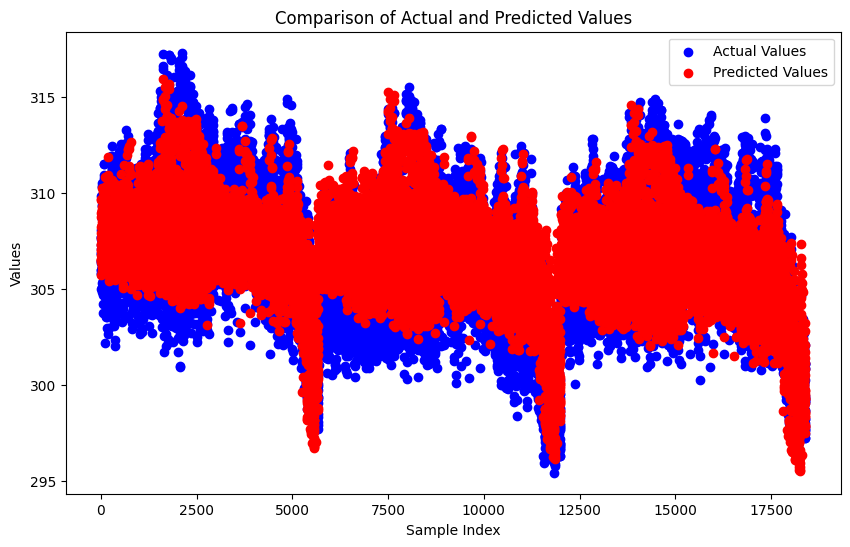

In [ ]:
# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y)), Y, color='blue', label='Actual Values')
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# 2005 Data Normalization - Detection Model

In [ ]:
df = fullData.copy()

# Create a new column LULC_combined for the 2005 data
df_2005 = df[df['year'] == 2005].copy()
# df_2005['LULC_combined'] = df_2005['LULC_1'] + df_2005['LULC_2'] + df_2005['LULC_3'] + df_2005['LULC_4'] + df_2005['LULC_5'] + df_2005['LULC_7'] + df_2005['LULC_8']



In [ ]:
# Normalize the data for 2005
scaler = MinMaxScaler()
df_2005[['LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']] = scaler.fit_transform(df_2005[['LULC_1','LULC_2','LULC_3','LULC_4','LULC_5',	'LULC_7','LULC_8', 'DEM', 'POP', 'year']])


## OLS Assessment Model-2005

In [ ]:
df.head()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_6,LULC_7,LULC_8,DEM,POP,year
0,303.2640,0.2977,0.0000,0.3298,0.1595,0.0,0.0419,0.0000,0.1711,11.2101,73.2147,2005
1,302.6289,0.3159,0.0000,0.3756,0.0551,0.0,0.0634,0.0009,0.1892,9.2329,163.8643,2005
2,302.3760,0.2175,0.0027,0.4697,0.0169,0.0,0.2513,0.0053,0.0365,9.7361,189.6371,2005
3,305.1244,0.0569,0.0000,0.5436,0.3967,0.0,0.0009,0.0000,0.0018,7.5387,308.8798,2005
4,304.3578,0.1157,0.0000,0.5234,0.2323,0.0,0.0781,0.0000,0.0505,6.8683,276.2893,2005


In [ ]:

# Prepare model input
X_2005 = df_2005[['LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']]
X_2005 = sm.add_constant(X_2005)
Y_2005 = df_2005['LST']

# Make predictions using a fitted model
Y_pred_2005 = model.predict(X_2005)


In [ ]:
# MSE
mse = mean_squared_error(Y_2005, Y_pred_2005)
print("MSE for the year 2005: ", mse)

# RMSE
rmse = sqrt(mean_squared_error(Y_2005, Y_pred_2005))
print("RMSE for the year 2005: ", rmse)

# R²
r2 = r2_score(Y_2005, Y_pred_2005)
print("R² for the year 2005: ", r2)

# MAE
mae = mean_absolute_error(Y_2005, Y_pred_2005)
print("MAE for the year 2005: ", mae)


MSE for the year 2005:  4.847493494323245
RMSE for the year 2005:  2.201702408211256
R² for the year 2005:  0.4800087271688196
MAE for the year 2005:  1.751359565528346


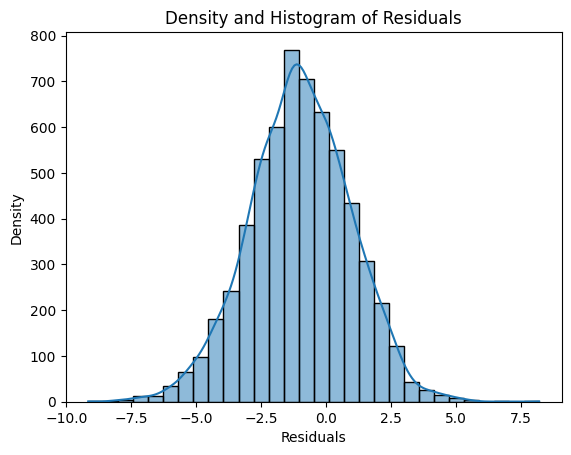

In [ ]:

# Calculate residuals
residuals = Y_2005 - Y_pred_2005

# Drawing histograms and kernel density estimation (KDE) using histplot
sns.histplot(residuals, kde=True, bins=30, edgecolor='black')
plt.title('Density and Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


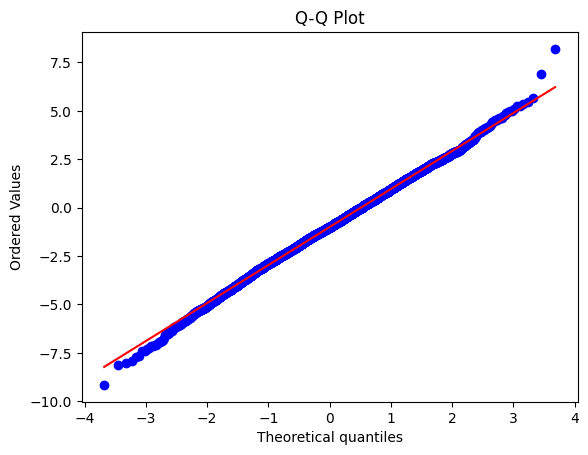

In [ ]:
# Q-Q
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [ ]:
# Feature importance analysis
feature_importance = pd.DataFrame({'Feature': X.columns[1:], 'Coefficient': model.params[1:]})
print(feature_importance.sort_values('Coefficient', ascending=False))


                     Feature  Coefficient
LULC_4_scaled  LULC_4_scaled       7.6255
LULC_3_scaled  LULC_3_scaled       5.0377
POP_scaled        POP_scaled       4.3447
LULC_7_scaled  LULC_7_scaled       3.9130
LULC_5_scaled  LULC_5_scaled       2.2075
LULC_8_scaled  LULC_8_scaled      -0.3371
LULC_1_scaled  LULC_1_scaled      -0.4488
LULC_2_scaled  LULC_2_scaled      -0.5754
year_scaled      year_scaled      -1.2567
DEM_scaled        DEM_scaled      -9.8579


# Randon Forest

In [ ]:
df_RF=data_normalize_train.drop('LULC_6', axis=1)
df_RF.head()

,LST,LULC_1,LULC_2,LULC_3,LULC_4,LULC_5,LULC_7,LULC_8,DEM,POP,...,LULC_1_scaled,LULC_2_scaled,LULC_3_scaled,LULC_4_scaled,LULC_5_scaled,LULC_7_scaled,LULC_8_scaled,DEM_scaled,POP_scaled,year_scaled
0,309.856,0.0624,0.0000,0.5482,0.3682,0.0000,0.0046,0.0073,7.5387,390.2333,...,0.1054,0.000,0.5528,0.3682,0.0000,0.0116,0.0129,0.0103,0.0349,0.0
1,307.692,0.0964,0.0000,0.4747,0.2048,0.0092,0.0230,0.0762,6.8683,321.5212,...,0.1627,0.000,0.4787,0.2048,0.0273,0.0581,0.1339,0.0093,0.0287,0.0
2,306.436,0.2629,0.0018,0.5481,0.0169,0.0027,0.0143,0.0499,7.1243,385.7429,...,0.4436,0.006,0.5527,0.0169,0.0080,0.0361,0.0877,0.0097,0.0345,0.0
3,306.886,0.2837,0.0000,0.5493,0.0787,0.0043,0.0035,0.0407,7.5685,254.8219,...,0.4787,0.000,0.5539,0.0787,0.0129,0.0088,0.0714,0.0104,0.0228,0.0
4,307.098,0.1435,0.0000,0.4501,0.1881,0.0223,0.0160,0.0882,6.6699,251.9394,...,0.2421,0.000,0.4538,0.1881,0.0663,0.0406,0.1550,0.0090,0.0225,0.0


In [ ]:
# sklearn has in-built functions for the traing-test set split
X_train, X_test, y_train, y_test = train_test_split(df_RF.iloc[:,11:22], df_RF.LST, train_size=0.8) #use random 80% of the data

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [ ]:
X_05= X_2005.drop('const', axis=1)

In [ ]:
y_pred_2005 = rf_model.predict(X_05)

In [ ]:
f1=pd.DataFrame({'Actual':Y_2005, 'Predicted':y_pred_2005})
f1

,Actual,Predicted
0,303.2640,309.5866
1,302.6289,306.3049
2,302.3760,306.7935
3,305.1244,309.7546
4,304.3578,308.9988
...,...,...
5996,300.2100,300.5021
5997,298.6840,300.7146
5998,299.2600,301.3835
5999,298.7740,301.8041


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_2005, y_pred_2005))
print('Mean Squared Error:', metrics.mean_squared_error(Y_2005, y_pred_2005))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_2005, y_pred_2005)))
r2 = r2_score(Y_2005, y_pred_2005)
print(f'R-squared (R2) score: {r2:.4f}')

Mean Absolute Error: 2.1715965027625943
Mean Squared Error: 6.978613524278772
Root Mean Squared Error: 2.6417065552931445
R-squared (R2) score: 0.2514


In [ ]:
# Calculate the absolute errors
errors = abs(y_pred_2005 - Y_2005)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_2005)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 2.17 degrees.
Accuracy: 99.29 %.


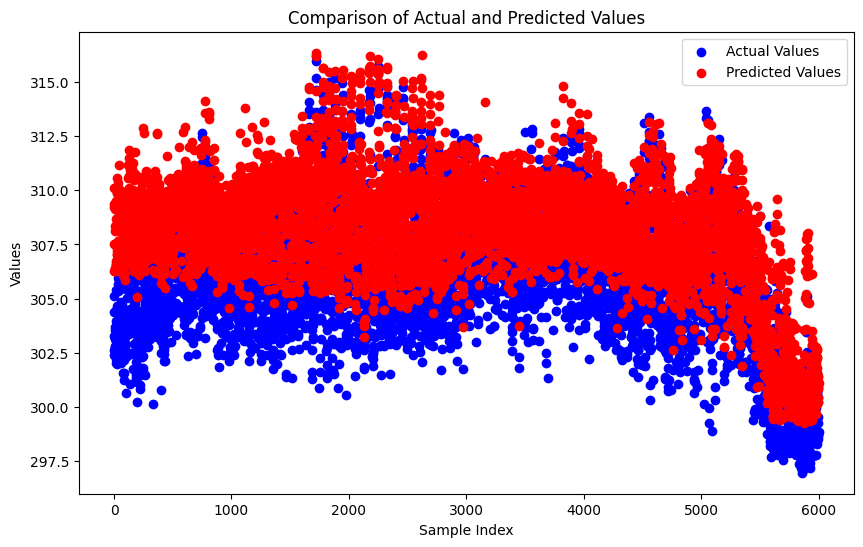

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(Y_2005)),Y_2005,color='blue',label='Actual Values')
plt.scatter(range(len(y_pred_2005)), y_pred_2005,color='red', label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Future Data
In this part we will import POP and LULC data in three scenarios: SSP2, SSP3, and SSP5. Predict LST for 2020-2100 separately using previous models.

## Import Data

In [ ]:
X_his_root = './Processed Data/IndependentVariableX/未来情景数据(预测用)'
def readData(path):
     # file root
    table = DBF(path, encoding='GBK')
    df = pd.DataFrame(iter(table))
    return df

POP_future_SSP2={}
POP_future_SSP3={}
POP_future_SSP5={}
LULC_future_SSP2={}
LULC_future_SSP3={}
LULC_future_SSP5={}
DEM_future_SSP2={}
DEM_future_SSP3={}
DEM_future_SSP5={}

In [ ]:
for n in range(2020,2101,10):
  i=str(n)
  path2_LULC=X_his_root+'/LULC_SSP_Table/{0}/reclass_drb_gcam45_rcp45_{1}.dbf'.format("SSP2",i)
  path3_LULC=X_his_root+'/LULC_SSP_Table/{0}/reclass_drb_gcamref_rcpavg_{1}.dbf'.format("SSP3",i)
  path5_LULC=X_his_root+'/LULC_SSP_Table/{0}/reclass_drb_gcamref_rcp85_{1}.dbf'.format("SSP5",i)
  path2_POP=X_his_root+'/Pop_SSP_Table/Proj_FPOP_{0}_{1}_Table.dbf'.format("SSP2",i)
  path3_POP=X_his_root+'/Pop_SSP_Table/Proj_FPOP_{0}_{1}_Table.dbf'.format("SSP3",i)
  path5_POP=X_his_root+'/Pop_SSP_Table/Proj_FPOP_{0}_{1}_Table.dbf'.format("SSP5",i)
  POP_future_SSP2[i]=readData(path2_POP)
  POP_future_SSP3[i]=readData(path3_POP)
  POP_future_SSP5[i]=readData(path5_POP)
  LULC_future_SSP2[i]=readData(path2_LULC)
  LULC_future_SSP3[i]=readData(path3_LULC)
  LULC_future_SSP5[i]=readData(path5_LULC)
  DEM_future_SSP2[i]=readData('./Processed Data/IndependentVariableX/HistoricalData/DEM_Table/DEM_Table.dbf')
  DEM_future_SSP3[i]=readData('./Processed Data/IndependentVariableX/HistoricalData/DEM_Table/DEM_Table.dbf')
  DEM_future_SSP5[i]=readData('./Processed Data/IndependentVariableX/HistoricalData/DEM_Table/DEM_Table.dbf')

In [ ]:
for n in range(2020,2101,10):
  i=str(n)
  print(POP_future_SSP2[i].describe())
  print(POP_future_SSP3[i].describe())
  print(POP_future_SSP5[i].describe())

             FID_    COUNT       AREA         SUM
count  32478.0000  32478.0    32478.0  32478.0000
mean   17949.5656      1.0  1000000.0    181.8905
std     9489.0889      0.0        0.0    443.7983
min        0.0000      1.0  1000000.0      0.0000
25%     9897.2500      1.0  1000000.0      7.8464
50%    18016.5000      1.0  1000000.0     47.9479
75%    26135.7500      1.0  1000000.0    150.9642
max    34257.0000      1.0  1000000.0  10109.5449
             FID_    COUNT       AREA         SUM
count  32478.0000  32478.0    32478.0  32478.0000
mean   17949.5656      1.0  1000000.0    181.6408
std     9489.0889      0.0        0.0    452.3395
min        0.0000      1.0  1000000.0      0.0000
25%     9897.2500      1.0  1000000.0      7.4535
50%    18016.5000      1.0  1000000.0     45.6861
75%    26135.7500      1.0  1000000.0    141.6670
max    34257.0000      1.0  1000000.0  10312.8428
             FID_    COUNT       AREA         SUM
count  32478.0000  32478.0    32478.0  32478.0000


In [ ]:
for n in range(2020,2101,10):
  i=str(n)
  print(LULC_future_SSP2[i].describe())
  print(LULC_future_SSP3[i].describe())
  print(LULC_future_SSP5[i].describe())

             FID_     VALUE_1     VALUE_2      VALUE_3     VALUE_4  \
count  32565.0000  3.2565e+04  3.2565e+04   32565.0000  3.2565e+04   
mean   17917.0887  1.3555e+05  2.5385e+04  162036.0663  4.2546e+04   
std     9499.5638  2.1607e+05  9.1650e+04  201410.3364  1.2118e+05   
min        0.0000  0.0000e+00  0.0000e+00       0.0000  0.0000e+00   
25%     9834.0000  0.0000e+00  0.0000e+00   24300.0000  0.0000e+00   
50%    17975.0000  9.0000e+03  0.0000e+00   74700.0000  0.0000e+00   
75%    26116.0000  1.9710e+05  6.3000e+03  225000.0000  1.5300e+04   
max    34257.0000  1.0188e+06  1.0404e+06  985500.0000  1.0323e+06   

           VALUE_5     VALUE_6      VALUE_7     VALUE_8  
count   32565.0000  3.2565e+04   32565.0000  3.2565e+04  
mean     4163.0216  5.0423e+05   36785.8867  8.4746e+04  
std     23624.7686  3.4407e+05   61390.3840  1.7758e+05  
min         0.0000  0.0000e+00       0.0000  0.0000e+00  
25%         0.0000  1.6650e+05       0.0000  1.8000e+03  
50%         0.0000  5

## Clean historical data

In [ ]:
for n in range(2020,2101,10):
  i=str(n)
  if n==2020:
    # 1.去除缺失值
    POP_future_SSP2[i].dropna(inplace=True)
    POP_future_SSP3[i].dropna(inplace=True)
    POP_future_SSP5[i].dropna(inplace=True)
    LULC_future_SSP2[i].dropna(inplace=True)
    LULC_future_SSP3[i].dropna(inplace=True)
    LULC_future_SSP5[i].dropna(inplace=True)
    DEM_future_SSP2[i].dropna(inplace=True)
    DEM_future_SSP3[i].dropna(inplace=True)
    DEM_future_SSP5[i].dropna(inplace=True)
    # 2.
    LULC_future_SSP2[i]['Row_sum'] = LULC_future_SSP2[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列
    LULC_future_SSP3[i]['Row_sum'] = LULC_future_SSP3[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列
    LULC_future_SSP5[i]['Row_sum'] = LULC_future_SSP5[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列
    LULC_future_SSP2[i]=LULC_future_SSP2[i][(LULC_future_SSP2[i]['Row_sum']>=980100)]
    LULC_future_SSP3[i]=LULC_future_SSP3[i][(LULC_future_SSP3[i]['Row_sum']>=980100)]
    LULC_future_SSP5[i]=LULC_future_SSP5[i][(LULC_future_SSP5[i]['Row_sum']>=980100)]
    # 3.
    LULC_future_SSP2[i]=LULC_future_SSP2[i][(LULC_future_SSP2[i]['VALUE_3']+LULC_future_SSP2[i]['VALUE_4'])/LULC_future_SSP2[i]['Row_sum']>=0.4]
    LULC_future_SSP3[i]=LULC_future_SSP3[i][(LULC_future_SSP3[i]['VALUE_3']+LULC_future_SSP3[i]['VALUE_4'])/LULC_future_SSP3[i]['Row_sum']>=0.4]
    LULC_future_SSP5[i]=LULC_future_SSP5[i][(LULC_future_SSP5[i]['VALUE_3']+LULC_future_SSP5[i]['VALUE_4'])/LULC_future_SSP5[i]['Row_sum']>=0.4]
    # 4.
    LULC_future_SSP2[i]=LULC_future_SSP2[i][LULC_future_SSP2[i]['VALUE_2']/LULC_future_SSP2[i]['Row_sum']<=0.3]
    LULC_future_SSP3[i]=LULC_future_SSP3[i][LULC_future_SSP3[i]['VALUE_2']/LULC_future_SSP3[i]['Row_sum']<=0.3]
    LULC_future_SSP5[i]=LULC_future_SSP5[i][LULC_future_SSP5[i]['VALUE_2']/LULC_future_SSP5[i]['Row_sum']<=0.3]
    # 5.
    POP_future_SSP2[i]=POP_future_SSP2[i][POP_future_SSP2[i]['SUM']!=0]
    POP_future_SSP3[i]=POP_future_SSP3[i][POP_future_SSP3[i]['SUM']!=0]
    POP_future_SSP5[i]=POP_future_SSP5[i][POP_future_SSP5[i]['SUM']!=0]

    POP_future_SSP2[i].reset_index(drop=True,inplace=True)
    POP_future_SSP3[i].reset_index(drop=True,inplace=True)
    POP_future_SSP5[i].reset_index(drop=True,inplace=True)
    LULC_future_SSP2[i].reset_index(drop=True,inplace=True)
    LULC_future_SSP3[i].reset_index(drop=True,inplace=True)
    LULC_future_SSP5[i].reset_index(drop=True,inplace=True)
    DEM_future_SSP2[i].reset_index(drop=True,inplace=True)
    DEM_future_SSP3[i].reset_index(drop=True,inplace=True)
    DEM_future_SSP5[i].reset_index(drop=True,inplace=True)

    index_2=list(set(POP_future_SSP2[i]['FID_']) & set(LULC_future_SSP2[i]['FID_'])& set(DEM_future_SSP2[i]['FID_']))
    index_3=list(set(POP_future_SSP3[i]['FID_']) & set(LULC_future_SSP3[i]['FID_'])& set(DEM_future_SSP3[i]['FID_']))
    index_5=list(set(POP_future_SSP5[i]['FID_']) & set(LULC_future_SSP5[i]['FID_'])& set(DEM_future_SSP5[i]['FID_']))
  else:
    LULC_future_SSP2[i]['Row_sum'] = LULC_future_SSP2[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列
    LULC_future_SSP3[i]['Row_sum'] = LULC_future_SSP3[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列
    LULC_future_SSP5[i]['Row_sum'] = LULC_future_SSP5[i].iloc[:,1:].sum(axis=1)  # 对1~8列按行求和，生成新列

  LULC_future_SSP2[i]=(LULC_future_SSP2[i][LULC_future_SSP2[i]['FID_'].isin(index_2)]).reset_index(drop=True)
  LULC_future_SSP3[i]=(LULC_future_SSP3[i][LULC_future_SSP3[i]['FID_'].isin(index_3)]).reset_index(drop=True)
  LULC_future_SSP5[i]=(LULC_future_SSP5[i][LULC_future_SSP5[i]['FID_'].isin(index_5)]).reset_index(drop=True)
  POP_future_SSP2[i]=(POP_future_SSP2[i][POP_future_SSP2[i]['FID_'].isin(index_2)]).reset_index(drop=True)
  POP_future_SSP3[i]=(POP_future_SSP3[i][POP_future_SSP3[i]['FID_'].isin(index_3)]).reset_index(drop=True)
  POP_future_SSP5[i]=(POP_future_SSP5[i][POP_future_SSP5[i]['FID_'].isin(index_5)]).reset_index(drop=True)
  DEM_future_SSP2[i] = (DEM_future_SSP2[i][DEM_future_SSP2[i]['FID_'].isin(index_2)]).reset_index(drop=True)
  DEM_future_SSP3[i] = (DEM_future_SSP3[i][DEM_future_SSP3[i]['FID_'].isin(index_3)]).reset_index(drop=True)
  DEM_future_SSP5[i] = (DEM_future_SSP5[i][DEM_future_SSP5[i]['FID_'].isin(index_5)]).reset_index(drop=True)

In [ ]:
len(LULC_future_SSP2['2050']['VALUE_1'])

6393

In [ ]:
len(DEM_future_SSP2['2050']['MEAN'])

6393

In [ ]:
SS2ByYear={}
SS3ByYear={}
SS5ByYear={}

for i in ['2050','2100']:
  SS2ByYear[i]=pd.DataFrame({
      "LULC_1":LULC_future_SSP2[i]["VALUE_1"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_2":LULC_future_SSP2[i]["VALUE_2"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_3":LULC_future_SSP2[i]["VALUE_3"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_4":LULC_future_SSP2[i]["VALUE_4"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_5":LULC_future_SSP2[i]["VALUE_5"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_7":LULC_future_SSP2[i]["VALUE_7"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_8":LULC_future_SSP2[i]["VALUE_8"]/LULC_future_SSP2[i]["Row_sum"],
      "DEM":DEM_future_SSP2[i]['MEAN'],
      "POP":POP_future_SSP2[i]['SUM'],
      "year":np.full(len(DEM_future_SSP2[i]), int(i))
  })
  SS3ByYear[i]=pd.DataFrame({
      "LULC_1":LULC_future_SSP3[i]["VALUE_1"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_2":LULC_future_SSP3[i]["VALUE_2"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_3":LULC_future_SSP3[i]["VALUE_3"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_4":LULC_future_SSP3[i]["VALUE_4"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_5":LULC_future_SSP3[i]["VALUE_5"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_7":LULC_future_SSP3[i]["VALUE_7"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_8":LULC_future_SSP3[i]["VALUE_8"]/LULC_future_SSP3[i]["Row_sum"],
      "DEM":DEM_future_SSP3[i]['MEAN'],
      "POP":POP_future_SSP3[i]['SUM'],
      "year":np.full(len(DEM_future_SSP3[i]), int(i))
  })
  SS5ByYear[i]=pd.DataFrame({
      "LULC_1":LULC_future_SSP5[i]["VALUE_1"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_2":LULC_future_SSP5[i]["VALUE_2"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_3":LULC_future_SSP5[i]["VALUE_3"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_4":LULC_future_SSP5[i]["VALUE_4"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_5":LULC_future_SSP5[i]["VALUE_5"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_7":LULC_future_SSP5[i]["VALUE_7"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_8":LULC_future_SSP5[i]["VALUE_8"]/LULC_future_SSP5[i]["Row_sum"],
      "DEM":DEM_future_SSP5[i]['MEAN'],
      "POP":POP_future_SSP5[i]['SUM'],
      "year":np.full(len(DEM_future_SSP5[i]), int(i))
  })

### Export data

In [ ]:
for n in [2050,2100]:
  i=str(n)
  output=pd.DataFrame({
      "FID":DEM_future_SSP2[i]['FID_'],
      "LULC_1":LULC_future_SSP2[i]["VALUE_1"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_2":LULC_future_SSP2[i]["VALUE_2"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_3":LULC_future_SSP2[i]["VALUE_3"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_4":LULC_future_SSP2[i]["VALUE_4"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_5":LULC_future_SSP2[i]["VALUE_5"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_6":LULC_future_SSP2[i]["VALUE_6"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_7":LULC_future_SSP2[i]["VALUE_7"]/LULC_future_SSP2[i]["Row_sum"],
      "LULC_8":LULC_future_SSP2[i]["VALUE_8"]/LULC_future_SSP2[i]["Row_sum"],
      "DEM":DEM_future_SSP2[i]['MEAN'],
      "POP":POP_future_SSP2[i]['SUM'],
      "year":np.full(len(DEM_future_SSP2[i]), n)
  })
  output.to_csv('./Cleaned Data/2020SSP2'+i+'.csv')
for n in range(2020,2101,10):
  i=str(n)
  output=pd.DataFrame({
      "FID":DEM_future_SSP3[i]['FID_'],
      "LULC_1":LULC_future_SSP3[i]["VALUE_1"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_2":LULC_future_SSP3[i]["VALUE_2"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_3":LULC_future_SSP3[i]["VALUE_3"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_4":LULC_future_SSP3[i]["VALUE_4"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_5":LULC_future_SSP3[i]["VALUE_5"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_6":LULC_future_SSP3[i]["VALUE_6"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_7":LULC_future_SSP3[i]["VALUE_7"]/LULC_future_SSP3[i]["Row_sum"],
      "LULC_8":LULC_future_SSP3[i]["VALUE_8"]/LULC_future_SSP3[i]["Row_sum"],
      "DEM":DEM_future_SSP3[i]['MEAN'],
      "POP":POP_future_SSP3[i]['SUM'],
      "year":np.full(len(DEM_future_SSP3[i]), n)
  })
  output.to_csv('./Cleaned Data/2020SSP3'+i+'.csv')
for n in range(2020,2101,10):
  i=str(n)
  output=pd.DataFrame({
      "FID":DEM_future_SSP5[i]['FID_'],
      "LULC_1":LULC_future_SSP5[i]["VALUE_1"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_2":LULC_future_SSP5[i]["VALUE_2"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_3":LULC_future_SSP5[i]["VALUE_3"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_4":LULC_future_SSP5[i]["VALUE_4"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_5":LULC_future_SSP5[i]["VALUE_5"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_6":LULC_future_SSP5[i]["VALUE_6"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_7":LULC_future_SSP5[i]["VALUE_7"]/LULC_future_SSP5[i]["Row_sum"],
      "LULC_8":LULC_future_SSP5[i]["VALUE_8"]/LULC_future_SSP5[i]["Row_sum"],
      "DEM":DEM_future_SSP5[i]['MEAN'],
      "POP":POP_future_SSP5[i]['SUM'],
      "year":np.full(len(DEM_future_SSP5[i]), n)
  })
  output.to_csv('./Cleaned Data/2020SSP5'+i+'.csv')

## Data description

In [ ]:
for n in range(2020,2101,10):
  i=str(n)
  print(POP_future_SSP2[i].describe())
  print(POP_future_SSP3[i].describe())
  print(POP_future_SSP5[i].describe())

             FID_   COUNT       AREA         SUM
count   6062.0000  6062.0     6062.0   6062.0000
mean   12002.3924     1.0  1000000.0    714.8526
std     5352.6457     0.0        0.0    820.2607
min       41.0000     1.0  1000000.0      0.1228
25%     8294.2500     1.0  1000000.0    265.4412
50%    11192.5000     1.0  1000000.0    485.6904
75%    14146.7500     1.0  1000000.0    852.0361
max    34244.0000     1.0  1000000.0  10109.5449
             FID_   COUNT       AREA         SUM
count   5960.0000  5960.0     5960.0   5960.0000
mean   11988.5755     1.0  1000000.0    734.6836
std     5333.3614     0.0        0.0    840.4511
min       41.0000     1.0  1000000.0      0.1228
25%     8296.7500     1.0  1000000.0    274.6881
50%    11187.5000     1.0  1000000.0    501.9927
75%    14112.2500     1.0  1000000.0    870.6869
max    34244.0000     1.0  1000000.0  10312.8428
             FID_   COUNT       AREA         SUM
count   5959.0000  5959.0     5959.0   5959.0000
mean   11988.5605   

# OLS model prediction for SSP2，SSP3，SSP5

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the normalization processor
scaler = MinMaxScaler()

# Initialize an empty dictionary to store processed data
processed_data = {}

# Define SSP and year list
ssps = ['SSP2', 'SSP3', 'SSP5']
years = ['2050', '2100']

# Read data and process it
for ssp in ssps:
    for year in years:
        # Build file path
        file_path = f'./Cleaned Data/{ssp}{year}.csv'

        # Read data
        df = pd.read_csv(file_path)

        # Combine LULC values
        # df['LULC_combined'] = df['LULC_1'] + df['LULC_2'] + df['LULC_3'] + df['LULC_4'] + df['LULC_5'] + df['LULC_7'] + df['LULC_8']

        # Normalized DEM, POP and year
        df[['LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']] = scaler.fit_transform(df[['LULC_1','LULC_2','LULC_3','LULC_4','LULC_5','LULC_7','LULC_8', 'DEM', 'POP', 'year']])

        # Save processed data
        processed_data[f'{ssp}_{year}'] = df


# Print some results to check
for key in processed_data:
    print(f"{key}:\n", processed_data[key][['FID', 'LULC_1_scaled','LULC_2_scaled','LULC_3_scaled','LULC_4_scaled','LULC_5_scaled','LULC_7_scaled','LULC_8_scaled', 'DEM', 'POP', 'year']].head(), "\n")


SSP2_2050:
    FID  LULC_1_scaled  LULC_2_scaled  LULC_3_scaled  LULC_4_scaled  \
0   27         0.7740          0.000         0.2327         0.1772   
1   41         0.0992          0.000         0.4617         0.4747   
2   42         0.1654          0.000         0.4224         0.3095   
3   57         0.4270          0.006         0.5506         0.0633   
4   58         0.5032          0.000         0.4930         0.1522   

   LULC_5_scaled  LULC_7_scaled  LULC_8_scaled     DEM       POP  year  
0         0.0000         0.0046         0.1588  9.1149   88.6151  2050  
1         0.0000         0.0070         0.0130  7.5387  288.7816  2050  
2         0.0446         0.0209         0.1361  6.8683  199.7386  2050  
3         0.0130         0.0315         0.0912  7.1243  253.5484  2050  
4         0.0210         0.0087         0.0718  7.5685  282.4814  2050   

SSP2_2100:
    FID  LULC_1_scaled  LULC_2_scaled  LULC_3_scaled  LULC_4_scaled  \
0   27         0.7336          0.000         

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the normalization processor
scaler = MinMaxScaler()

# Initialize an empty dictionary to store processed data
processed_data = {}

# Define SSP and year list
ssps = ['SSP2', 'SSP3', 'SSP5']
years = ['2050', '2100']

# Read data and process it
for ssp in ssps:
    for year in years:
        # Build file path
        file_path = f'./Cleaned Data/2020{ssp}{year}.csv'

        # Read data
        df = pd.read_csv(file_path)

        # Normalized DEM, POP and year
        df[['LULC_1_scaled', 'LULC_2_scaled', 'LULC_3_scaled', 'LULC_4_scaled', 'LULC_5_scaled', 'LULC_7_scaled', 'LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']] = scaler.fit_transform(df[['LULC_1', 'LULC_2', 'LULC_3', 'LULC_4', 'LULC_5', 'LULC_7', 'LULC_8', 'DEM', 'POP', 'year']])

        # Save processed data
        processed_data[f'{ssp}_{year}'] = df

# Print some results to check
for key in processed_data:
    print(f"{key}:\n", processed_data[key][['FID', 'LULC_1_scaled', 'LULC_2_scaled', 'LULC_3_scaled', 'LULC_4_scaled', 'LULC_5_scaled', 'LULC_7_scaled', 'LULC_8_scaled', 'DEM', 'POP', 'year']].head(), "\n")


SSP2_2050:
    FID  LULC_1_scaled  LULC_2_scaled  LULC_3_scaled  LULC_4_scaled  \
0   41         0.1007          0.000         0.4617         0.4747   
1   42         0.1678          0.000         0.4224         0.3095   
2   57         0.4332          0.006         0.5506         0.0633   
3   58         0.5106          0.000         0.4930         0.1522   
4   59         0.2443          0.000         0.4463         0.2513   

   LULC_5_scaled  LULC_7_scaled  LULC_8_scaled     DEM       POP  year  
0         0.0000         0.0070         0.0130  7.5387  288.7816  2050  
1         0.0446         0.0209         0.1361  6.8683  199.7386  2050  
2         0.0130         0.0315         0.0912  7.1243  253.5484  2050  
3         0.0210         0.0087         0.0718  7.5685  282.4814  2050  
4         0.0823         0.0225         0.1526  6.6699  168.2748  2050   

SSP2_2100:
    FID  LULC_1_scaled  LULC_2_scaled  LULC_3_scaled  LULC_4_scaled  \
0   41         0.0906          0.000         

In [ ]:
# 使用模型进行预测
def predict_with_model(model, data):
    # 准备数据
    X = data[['LULC_1_scaled', 'LULC_2_scaled', 'LULC_3_scaled', 'LULC_4_scaled', 'LULC_5_scaled', 'LULC_7_scaled', 'LULC_8_scaled', 'DEM_scaled', 'POP_scaled', 'year_scaled']]
    X = sm.add_constant(X)

    # 进行预测
    return model.predict(X)

# 对每个SSP数据集进行预测
for key in processed_data:
    # 获取原始数据
    print(key)
    original_data = processed_data[key]

    # 使用模型进行预测
    predicted_LST = predict_with_model(model, original_data)

    # 将预测结果添加到原始数据中
    original_data['Predicted_LST'] = predicted_LST

    # original_data[['FID', 'LULC_1', 'LULC_2', 'LULC_3', 'LULC_4', 'LULC_5', 'LULC_7', 'LULC_8', 'DEM', 'POP', 'year', 'Predicted_LST']].to_csv('./Cleaned Data/_2020_Predict_'+key+'.csv',index=False)
    # 打印预测结果
    print(f"\n{key} Predictions:")
    print(original_data[['FID', 'LULC_1', 'LULC_2', 'LULC_3', 'LULC_4', 'LULC_5', 'LULC_7', 'LULC_8', 'DEM', 'POP', 'year', 'Predicted_LST']].head())

SSP2_2050

SSP2_2050 Predictions:
   FID  LULC_1  LULC_2  LULC_3  LULC_4  LULC_5  LULC_7  LULC_8     DEM  \
0   41  0.0551  0.0000  0.4536  0.4747  0.0000  0.0028  0.0073  7.5387   
1   42  0.0918  0.0000  0.4151  0.3095  0.0092  0.0083  0.0771  6.8683   
2   57  0.2371  0.0018  0.5410  0.0633  0.0027  0.0125  0.0517  7.1243   
3   58  0.2794  0.0000  0.4844  0.1522  0.0043  0.0035  0.0407  7.5685   
4   59  0.1337  0.0000  0.4385  0.2513  0.0169  0.0089  0.0865  6.6699   

        POP  year  Predicted_LST  
0  288.7816  2050       310.0516  
1  199.7386  2050       308.6354  
2  253.5484  2050       307.2944  
3  282.4814  2050       307.5960  
4  168.2748  2050       308.3476  
SSP2_2100

SSP2_2100 Predictions:
   FID  LULC_1  LULC_2  LULC_3  LULC_4  LULC_5  LULC_7  LULC_8     DEM  \
0   41  0.0496  0.0000  0.4114  0.5234  0.0000  0.0028  0.0073  7.5387   
1   42  0.0918  0.0000  0.4224  0.3095  0.0073  0.0083  0.0771  6.8683   
2   57  0.2112  0.0018  0.5624  0.0633  0.0018  0.0125 

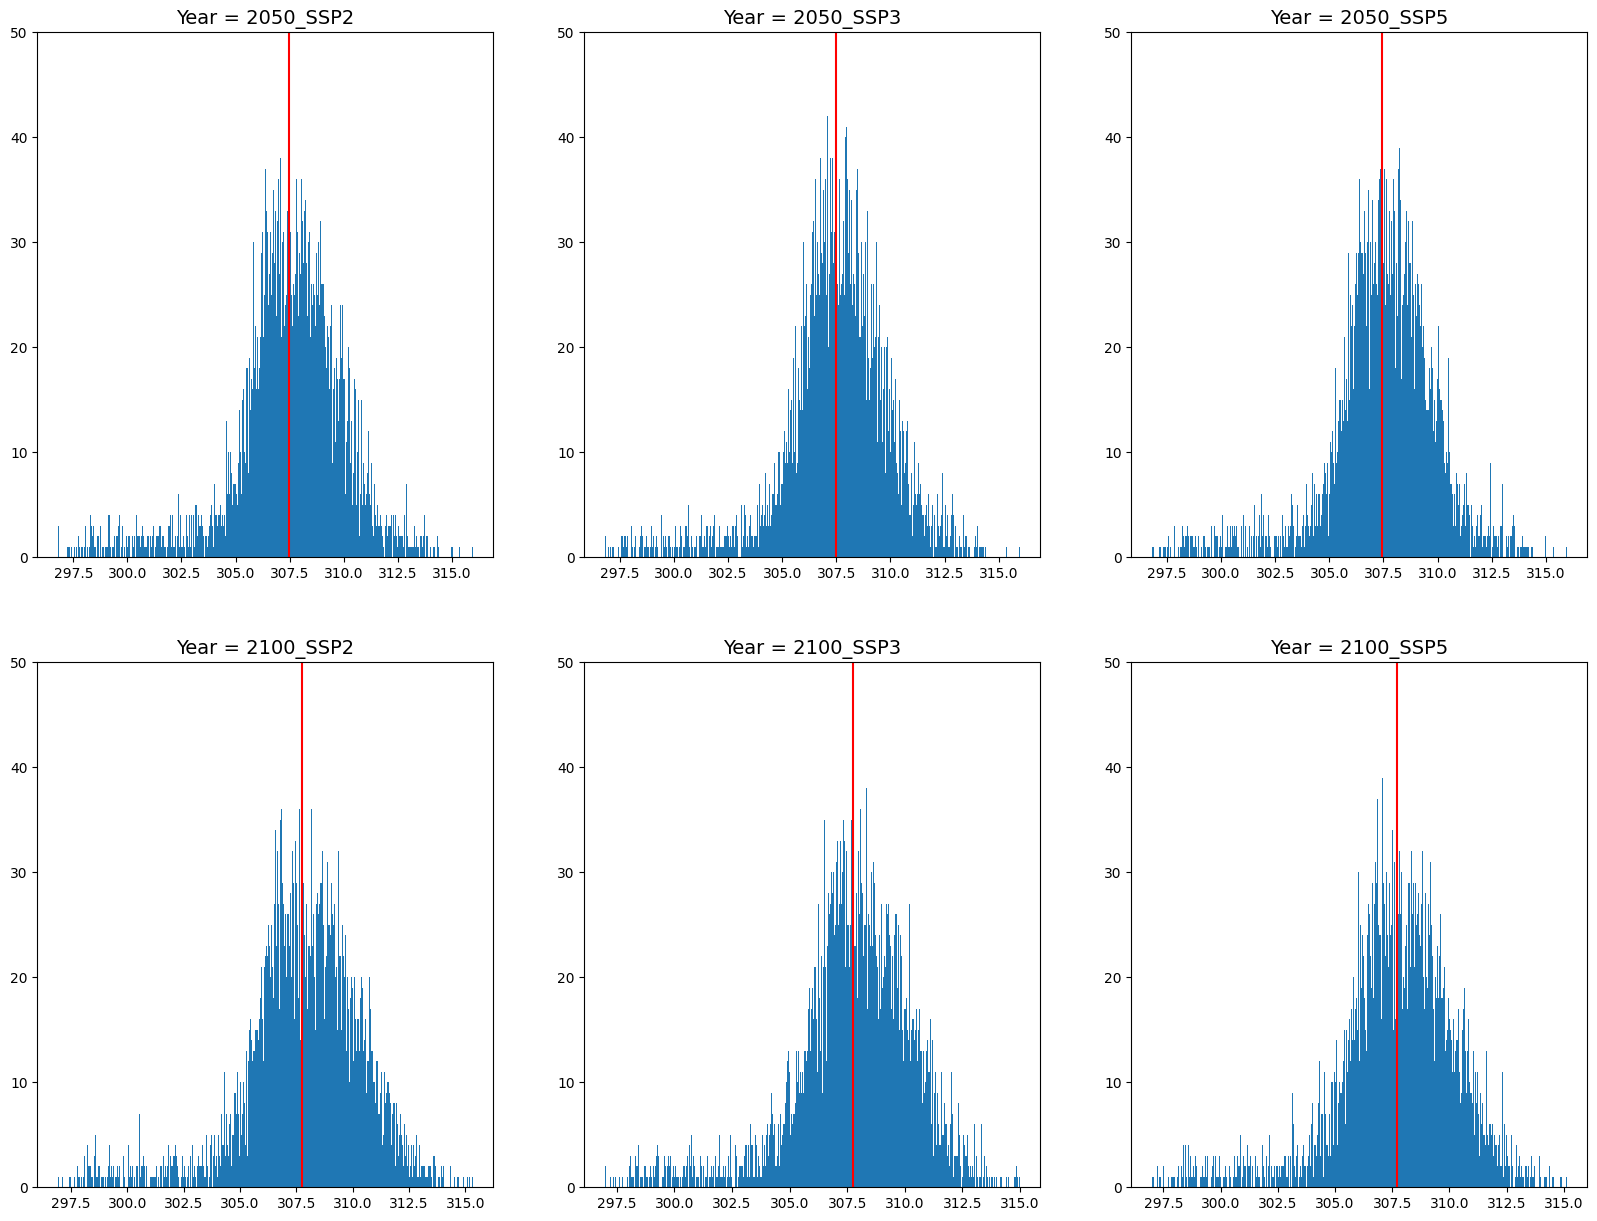

In [ ]:
plt.figure(figsize = (20,15))
n=1
mean=[]
std=[]
index=[]
POP=[]
for i in ['2050','2100']:
  for j in ['SSP2','SSP3','SSP5']:
    plt.subplot(230+n)
    # Build file path
    file_path = f'./Cleaned Data/Predict_{j}_{i}.csv'
    # Read data
    df = pd.read_csv(file_path)
    plt.hist(df['Predicted_LST'],bins=800)
    #308
    mean.append(df['Predicted_LST'].mean())
    std.append(df['Predicted_LST'].std())
    index.append(i+'-'+j)
    POP.append((df[df['Predicted_LST']>=308])['POP'].sum())
    plt.axvline(df['Predicted_LST'].mean(), color='r')
    plt.ylim(0,50)
    plt.title('Year = '+i+'_'+j, fontsize = 14)
    n+=1
result_m_s=pd.DataFrame({'mean':mean,'std':std,'pop':POP},index=index)

In [ ]:
result_m_s

,mean,std,pop
2050-SSP2,307.4556,2.5598,3.1776e+06
2050-SSP3,307.4702,2.5483,3.4737e+06
2050-SSP5,307.4433,2.5576,2.9775e+06
2100-SSP2,307.7341,2.6942,2.9699e+06
2100-SSP3,307.7420,2.6647,4.2915e+06
2100-SSP5,307.6995,2.6857,2.4138e+06
